In [1]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn

from utils.training import *
from utils.utils import *

from models.infersent import *
from models.self_attentive import *
from models.bert import *
from models.classification_model import ClassificationNet

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

sns.set(font_scale=1.3)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONASSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything()

# Data

In [3]:
data = pd.read_csv('emotions_short.csv', index_col='Unnamed: 0')
data.head()

,Text,Emotion
0,im grabbing a minute to post i feel greedy wrong,anger
1,i am feeling grouchy,anger
2,i think it s the easiest time of year to feel ...,anger
3,i feel irritated and rejected without anyone d...,anger
4,i already feel like i fucked up though because...,anger


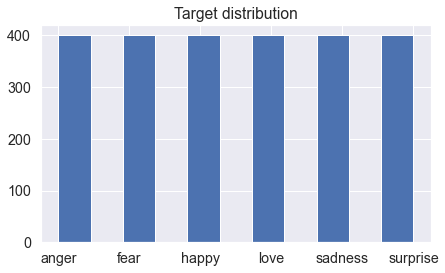

In [4]:
plt.figure(figsize=(7, 4))
plt.title('Target distribution')
plt.hist(data['Emotion'], bins=11);

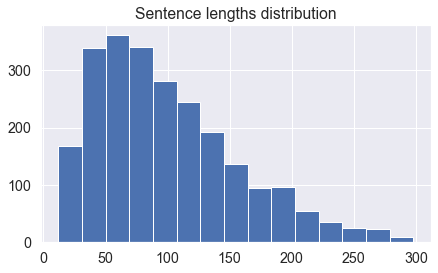

In [5]:
lens = []
for sentence in data['Text']:
    lens.append(len(sentence))

plt.figure(figsize=(7, 4))
plt.title('Sentence lengths distribution')
plt.hist(lens, bins=15);

# BERT

In [4]:
train_dataloader, val_dataloader, val_dataloader_shuffled = get_bert_dataloaders(data['Text'], data['Emotion'], shuffle=True)

  0%|          | 0/480 [00:00<?, ?it/s]

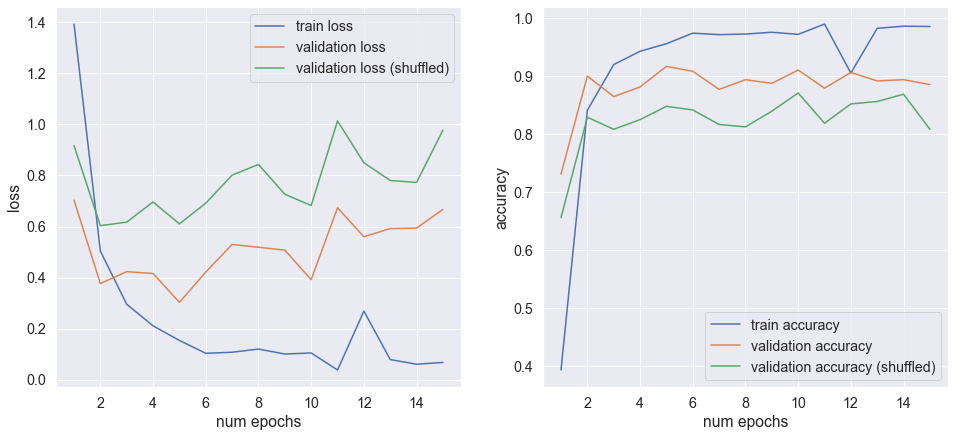

epoch number: 15
time per epoch: 43.284s
validation acc: 88.5
validation loss: 0.667


In [5]:
model = ClassificationModel(num_classes=6, hidden_size=384).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

model, history = bert_shuffled_training_loop(
    model, criterion, optimizer, train_dataloader, 
    val_dataloader, val_dataloader_shuffled, num_epochs=15,
    model_path_to_save='./weights/bert_shuffled.pth',
    history_path_to_save='./histories/bert_shuffled.csv',
    shuffled_model_path_to_save='./weights/bert_best_shuffled.pth',
    shuffled_history_path_to_save='./histories/bert_best_shuffled.pth'
)

In [12]:
label_encoder = LabelEncoder().fit(data['Emotion'])

In [32]:
model = ClassificationModel(num_classes=6, hidden_size=384).to(device)
model.load_state_dict(torch.load('./weights/bert_shuffled.pth'))
model.eval()

not_shuffled_pred = []
for val_batch in tqdm(val_dataloader):
        val_batch = {key: value.to(device) for key, value in val_batch.items()}
        input_ids, attention_mask = val_batch['input_ids'], val_batch['attention_mask']
        target = val_batch['target']
        predictions = model(input_ids, attention_mask)
        target = target.detach().cpu().numpy()
        predictions = predictions.detach().cpu().numpy().argmax(axis=1)
        not_shuffled_pred.extend(label_encoder.inverse_transform(predictions))
        
not_shuffled_pred = np.array(not_shuffled_pred)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/30 [00:00<?, ?it/s]

In [25]:
model = ClassificationModel(num_classes=6, hidden_size=384).to(device)
model.load_state_dict(torch.load('./weights/bert_best_shuffled.pth'))
model.eval()

shuffled_pred = []
for val_batch in tqdm(val_dataloader_shuffled):
        val_batch = {key: value.to(device) for key, value in val_batch.items()}
        input_ids, attention_mask = val_batch['input_ids'], val_batch['attention_mask']
        target = val_batch['target']
        predictions = model(input_ids, attention_mask)
        target = target.detach().cpu().numpy()
        predictions = predictions.detach().cpu().numpy().argmax(axis=1)
        shuffled_pred.extend(label_encoder.inverse_transform(predictions))
        
shuffled_pred = np.array(shuffled_pred)

In [34]:
df = pd.DataFrame(np.hstack((not_shuffled_pred.reshape(-1, 1), shuffled_pred.reshape(-1, 1))))
df.columns = ['not shuffled', 'shuffled']
df.to_csv('shuffled_predictions.csv', index=False)

# Self-Attentive

In [22]:
max_len = 150
emb_size = 100

X, y, word2idx, embedding_weights = preprocess_data(data['Text'], data['Emotion'], 
                                                    './GloVe/glove.6B.100d.txt', emb_size, max_len)
pad_symbol_value = X[0][-1]

0it [00:00, ?it/s]

  0%|          | 0/5562 [00:00<?, ?it/s]

In [23]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [24]:
def shuffle_sentence(sentence):
    n = len(sentence)
    while True:
        permutation = np.random.permutation(n)
        if (permutation != np.arange(n)).all() == 0:
            return np.array(sentence)[permutation]
        
        
def shuffle_sentences(sentences):
    shuffled_sentences = []
    for sentence in tqdm(sentences):
        index_1 = np.where(sentence != pad_symbol_value)[0]
        index_2 = np.where(sentence == pad_symbol_value)[0]
        part_1, part_2 = sentence[index_1], sentence[index_2]
        shuffled_sentences.append(np.append(shuffle_sentence(part_1), part_2))
        
    return np.array(shuffled_sentences)


X_val = shuffle_sentences(X_val)

  0%|          | 0/480 [00:00<?, ?it/s]

In [25]:
train_dataset = EmotionsDataset(X_train, y_train)
val_dataset = EmotionsDataset(X_val, y_val)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32)

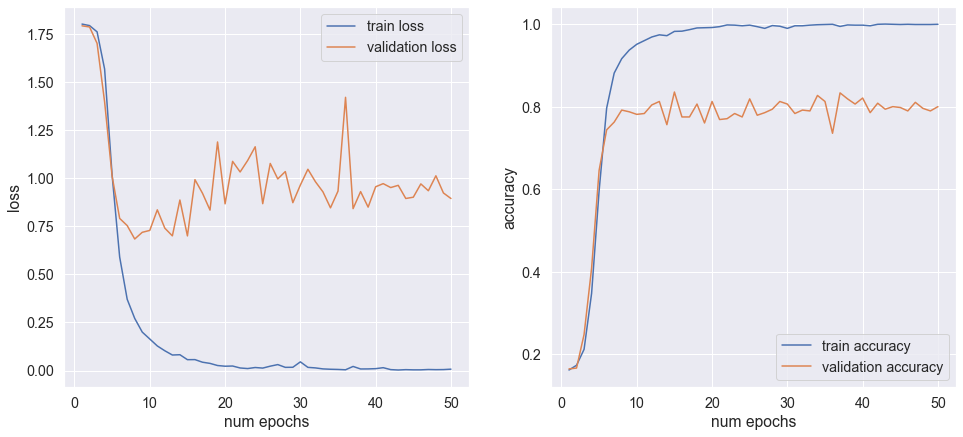

epoch number: 50
time per epoch: 2.665s
validation acc: 80.0
validation loss: 0.894


In [27]:
vocab_size, emb_size = embedding_weights.shape

model = SelfAttentiveClassifierNet(vocab_size, emb_size, 6, pre_embd=embedding_weights).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)

model, history = train(
    model, criterion, optimizer,
    train_dataloader, val_dataloader, num_epochs=50,
    model_path_to_save='./weights/self_attentive_2.pth',
    history_path_to_save='./histories/self_attentive_2.csv'
)

In [28]:
model = SelfAttentiveClassifierNet(vocab_size, emb_size, 6).to(device)
model.load_state_dict(torch.load('./weights/self_attentive_2.pth'))
model.eval()

self_attentive_predictions = []
for X_val_batch, y_val_batch in val_dataloader:
    X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

    predictions = model(X_val_batch)

    target = y_val_batch.detach().cpu().numpy()
    predictions = predictions.detach().cpu().numpy().argmax(axis=1)

    self_attentive_predictions.extend(label_encoder.inverse_transform(predictions))

# InferSent

In [15]:
max_len = 150
emb_size = 300

X, y, word2idx, embedding_weights = preprocess_data(data['Text'], data['Emotion'], 
                                                    './GloVe/glove.840B.300d.txt', emb_size, max_len, shuffle=True)
pad_symbol_value = X[0][-1]

0it [00:00, ?it/s]

  0%|          | 0/5562 [00:00<?, ?it/s]

  0%|          | 0/2400 [00:00<?, ?it/s]

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [18]:
X_val = shuffle_sentences(X_val)

train_dataset = EmotionsDataset(X_train, y_train)
val_dataset = EmotionsDataset(X_val, y_val)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32)

  0%|          | 0/480 [00:00<?, ?it/s]

In [19]:
V = 1
MODEL_PATH = './infersent%s.pkl' % V
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048, 'pool_type': 'max', 'dpout_model': 0.0, 'version': V}

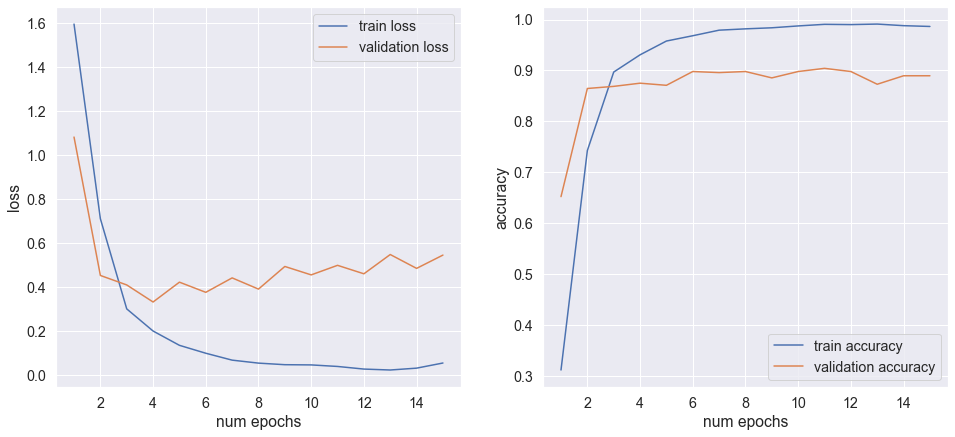

epoch number: 15
time per epoch: 36.706s
validation acc: 89.0
validation loss: 0.545


In [20]:
vocab_size, emb_size = embedding_weights.shape

model = Classifier(vocab_size, emb_size, MODEL_PATH, params_model, 6, 2048, max_len, pre_embd=embedding_weights).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

model, history = train(
    model, criterion, optimizer,
    train_dataloader, val_dataloader, num_epochs=15,
    model_path_to_save='./weights/infersent_2.pth',
    history_path_to_save='./histories/infersent_2.csv'
)

In [21]:
model = Classifier(vocab_size, emb_size, MODEL_PATH, params_model, 6, 2048, max_len).to(device)
model.load_state_dict(torch.load('./weights/infersent_2.pth'))
model.eval()

infersent_predictions = []
for X_val_batch, y_val_batch in val_dataloader:
    X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

    predictions = model(X_val_batch)

    target = y_val_batch.detach().cpu().numpy()
    predictions = predictions.detach().cpu().numpy().argmax(axis=1)

    infersent_predictions.extend(label_encoder.inverse_transform(predictions))

# Bag-Of-Words

In [30]:
def shuffle_sentence(sentence):
    n = len(sentence)
    while True:
        permutation = np.random.permutation(n)
        if (permutation != np.arange(n)).all() == 0:
            return np.array(sentence)[permutation]
        
        
def shuffle_sentences(sentences):
    shuffled_sentences = []
    for sentence in tqdm(sentences):
        tokens = sentence.split(' ')
        shuffled_sentences.append(' '.join(shuffle_sentence(tokens)))
        
    return shuffled_sentences

In [31]:
vectorizer = CountVectorizer()
vectorizer.fit(data['Text'])
sentences = pd.read_csv('val_dataset.csv')['Text']
sentences = shuffle_sentences(sentences)
bag_of_words_embeddings_sh = vectorizer.transform(sentences).toarray()

  0%|          | 0/480 [00:00<?, ?it/s]

In [32]:
model = ClassificationNet(bag_of_words_embeddings_sh.shape[1], 6).to(device)
model.load_state_dict(torch.load('./classification_weights/bag_of_words_classification.pht'))
model.eval()
val_dataloader = DataLoader(ClassificationDataset(bag_of_words_embeddings_sh, y_val), batch_size=32)

bag_of_words_predictions = []
for X_val_batch, y_val_batch in val_dataloader:
    X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

    predictions = model(X_val_batch)

    target = y_val_batch.detach().cpu().numpy()
    predictions = predictions.detach().cpu().numpy().argmax(axis=1)

    bag_of_words_predictions.extend(label_encoder.inverse_transform(predictions))

# TF-IDF

In [33]:
vectorizer = TfidfVectorizer()
vectorizer.fit(data['Text'])
sentences = pd.read_csv('val_dataset.csv')['Text']
sentences = shuffle_sentences(sentences)
tf_idf_embeddings_sh = vectorizer.transform(sentences).toarray()

  0%|          | 0/480 [00:00<?, ?it/s]

In [34]:
model = ClassificationNet(tf_idf_embeddings_sh.shape[1], 6).to(device)
model.load_state_dict(torch.load('./classification_weights/tf_idf_classification.pht'))
model.eval()
val_dataloader = DataLoader(ClassificationDataset(tf_idf_embeddings_sh, y_val), batch_size=32)

tf_idf_predictions = []
for X_val_batch, y_val_batch in val_dataloader:
    X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

    predictions = model(X_val_batch)

    target = y_val_batch.detach().cpu().numpy()
    predictions = predictions.detach().cpu().numpy().argmax(axis=1)

    tf_idf_predictions.extend(label_encoder.inverse_transform(predictions))

# Predictions

In [36]:
df = pd.DataFrame({'Bag-Of-Words': bag_of_words_predictions, 
              'TF-IDF': tf_idf_predictions, 
              'InferSent': infersent_predictions, 
              'Self-Attentive': self_attentive_predictions
             })

In [38]:
bert_predictions = pd.read_csv('shuffled_predictions_bert.csv')['shuffled']
df['BERT'] = bert_predictions
df.to_csv('shuffled_predictions.csv', index=False)